In [16]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import matplotlib
from scipy.fft import fft, fftfreq, fftshift
import glob
import os
import pandas as pd

songdir = os.path.join('.', 'data', 'example_songs')  # change this to the path to all the .mp3 songs
songs = glob.glob(os.path.join(songdir, '*.mp3'))
print(f'found {len(songs)} songs: {songs}')


found 4 songs: ['.\\data\\example_songs\\Billie Jean.mp3', '.\\data\\example_songs\\Enter Sandman.mp3', '.\\data\\example_songs\\Hey Jude.mp3', '.\\data\\example_songs\\Somebody To Love.mp3']


In [17]:

def calc_fft(t, y):
    dt = t[1]-t[0]
    N = len(t)
    yfft = fftshift(fft(y)) * 2/N   # normalize
    freq_vec = fftshift(fftfreq(N, d=dt))  # cycles/s

    ihalf = int(len(yfft)/2)
    yfft = yfft[ihalf:]
    freq_vec = freq_vec[ihalf:]

    return yfft, freq_vec


df_songs = pd.DataFrame(columns = ['y', 't', 'yfft', 'freq_vec', 'song_name', 'spectrogram'], index = songs)

for song in songs:
    y = librosa.load(song)
    fn = y[1]  # frequency
    y = y[0]
    y = y/np.mean(np.abs(y)) # normalize
    t = np.arange(0, len(y)/fn, 1/fn)

    yfft, freq_vec = calc_fft(t, y)

    df_songs.at[song, 'y'] = y
    df_songs.at[song, 't'] = t
    df_songs.at[song, 'yfft'] = yfft
    df_songs.at[song, 'freq_vec'] = freq_vec
    df_songs.at[song, 'song_name'] = os.path.basename(song).rstrip('.mp3')

print(df_songs.head())


                                                                                           y  \
.\data\example_songs\Billie Jean.mp3       [4.1419536e-23, 3.5629032e-23, -6.963757e-23, ...   
.\data\example_songs\Enter Sandman.mp3     [-6.9778607e-11, 7.1657506e-11, -8.51244e-11, ...   
.\data\example_songs\Hey Jude.mp3          [-1.7427189e-12, 3.9569327e-11, -1.931807e-10,...   
.\data\example_songs\Somebody To Love.mp3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                                           t  \
.\data\example_songs\Billie Jean.mp3       [0.0, 4.5351473922902495e-05, 9.07029478458049...   
.\data\example_songs\Enter Sandman.mp3     [0.0, 4.5351473922902495e-05, 9.07029478458049...   
.\data\example_songs\Hey Jude.mp3          [0.0, 4.5351473922902495e-05, 9.07029478458049...   
.\data\example_songs\Somebody To Love.mp3  [0.0, 4.5351473922902495e-05, 9.07029478458049...   

                                      

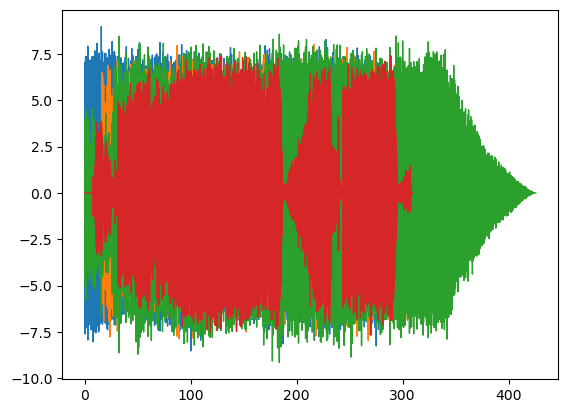

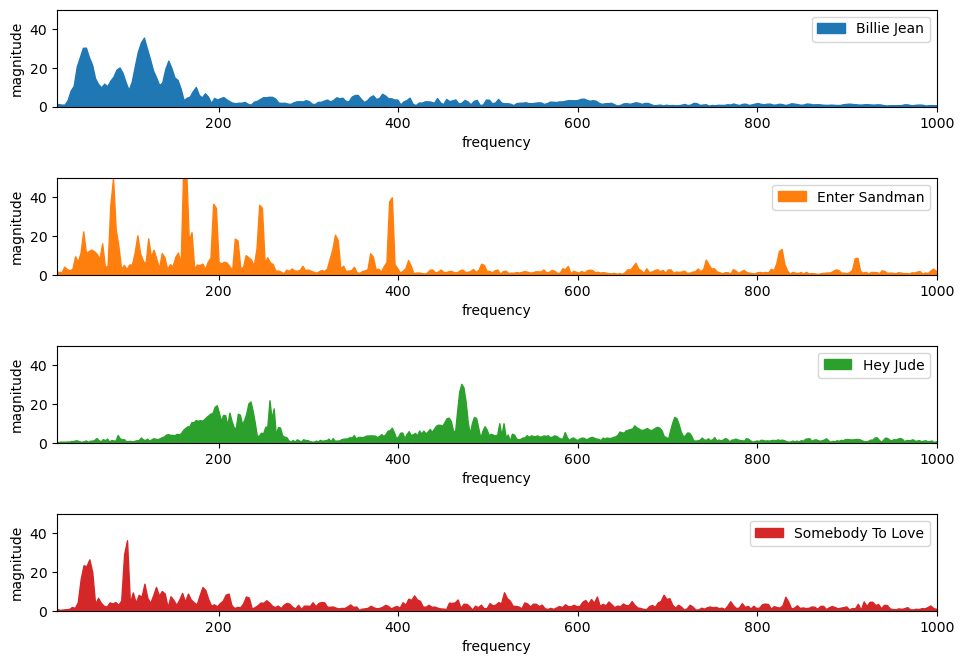

In [18]:
def decimate_sig(x, w):
    pad_size = np.ceil(float(x.size)/w)*w - x.size
    pad_size = int(pad_size)
    x = np.append(x, np.zeros(pad_size)*np.NaN)
    x = np.nanmean(x.reshape(-1,w), axis=1)
    return x


fig, ax = plt.subplots(1, 1)

h = {}
for ind in df_songs.index:
    h[ind] = ax.plot(df_songs.loc[ind, 't'], df_songs.loc[ind, 'y'], lw = 1)

fig, ax = plt.subplots(len(df_songs), 1)

for i,ind in enumerate(df_songs.index):
    freq_vec = df_songs.loc[ind, 'freq_vec']
    yfft = df_songs.loc[ind, 'yfft']
    lbl = df_songs.loc[ind, 'song_name']

    freq_vec = decimate_sig(freq_vec, 1000)
    yfft = decimate_sig(yfft, 1000)  # make less data to plot
    yfft = np.abs(yfft)
    yfft = yfft 
    yfft = yfft/np.mean(yfft) # normalize (if desired)

    ax[i].fill_between(freq_vec, yfft, 0, lw = 1, label = lbl, color = h[ind][0].get_color())  
    ax[i].legend()
    ax[i].set_ylim([0, 50])
    ax[i].set_xlim([20, 1000])
    ax[i].set_xlabel('frequency')  
    ax[i].set_ylabel('magnitude')  

fig.set_size_inches(10, 7)
fig.tight_layout(pad = 2)



In [19]:

for ind in df_songs.index:
    y = df_songs.loc[ind, 'y']
    S = librosa.feature.melspectrogram(y=y, sr=fn, n_mels=128,
                                        fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    df_songs.at[ind, 'spectrogram'] = S_dB


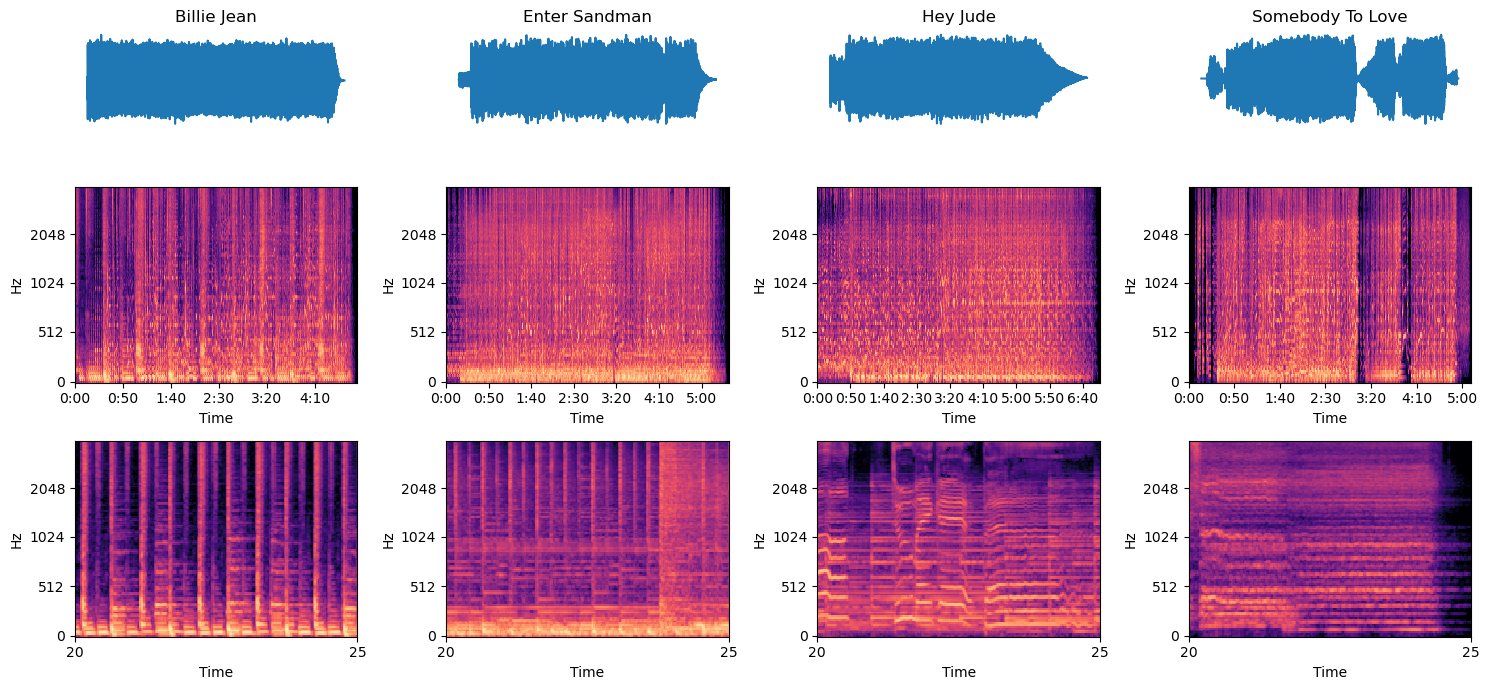

In [20]:

fig, ax = plt.subplots(3,len(df_songs), gridspec_kw={'height_ratios': [1, 2, 2]})

for i, ind in enumerate(df_songs.index):

    y = df_songs.loc[ind, 'y']
    S_dB = df_songs.loc[ind, 'spectrogram']
    song_name = df_songs.loc[ind, 'song_name']

    ax[0,i].plot(y)
    ax[0,i].set_axis_off()
    img = librosa.display.specshow(S_dB, x_axis='time',
                            y_axis='mel', sr=fn,
                            fmax=4000, ax=ax[1,i])
    
    img = librosa.display.specshow(S_dB, x_axis='time',
                            y_axis='mel', sr=fn,
                            fmax=4000, ax=ax[2,i])
    ax[2, i].set_xlim((20, 25))
    ax[2, i].locator_params(axis='x', nbins=3) 

    ax[0,i].set_title(song_name)
    


fig.set_size_inches((15, 7))
fig.tight_layout()